# Toy MC check of unbinned loglh scan

In [1]:
import os
import re
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

def set_style(tick_label_size=16, font_size=18):
    import matplotlib
    matplotlib.rc('xtick', labelsize=tick_label_size)
    matplotlib.rc('ytick', labelsize=tick_label_size)
    matplotlib.rc('font', size=font_size)

set_style()

In [2]:
import jax
import flax
from flax import nn, optim, serialization

In [3]:
from lib.params import mdn

In [4]:
path_data = './mcsamples'
path_models = './dat'

In [5]:
def draw_1d_projections(ax, data, bins=250, weights=None):
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for idx, lbl in enumerate(labels):
        ax[idx].hist(data[:,idx], bins=bins, weights=weights);
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [6]:
def model_file(re, im, ch):
    return f'nn_model_3d_gs{re:.2f}_{im:.2f}_ch{ch}.dat'

In [7]:
def norm_file(re, im, ch):
    return f'norm_gs{re:.2f}_{im:.2f}_ch{ch}.npz'

In [8]:
def smeared_samp_file(re, im, ch):
    return f'mc_ddpip_3d_gs{re:.2f}_{im:.2f}_ch{ch}_smeared.npy'

In [9]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq)
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

In [10]:
def get_sample(re, im, ch):
    return get_vars(np.load(os.path.join(path_data, smeared_samp_file(re, im, ch))))

In [11]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=16)
        x = nn.relu(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)

In [12]:
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer

In [13]:
# @flax.struct.dataclass
# class ModelState:
#     model: nn.Model

In [14]:
def get_norm(re, im, ch):
    fname = os.path.join(path_models, norm_file(re, im, ch))
    if not os.path.isfile(fname):
        print('get_norm: {fname} not found')
    ndata = np.load(fname)
    return (ndata['mean'], ndata['std'])

In [15]:
def read_models(path):
    re_model = re.compile(r'.*nn_model_3d_gs(\d+\.\d+)_(\d\.\d+)_ch(\d+)\.dat')
    models = {}
    
    key = jax.random.PRNGKey(0)
    _, initial_params = NN.init(key, np.zeros((10, 3)))
    
    model = nn.Model(NN, initial_params)
    
    adam = optim.Adam(learning_rate=0.003)
    optimizer = adam.create(model)
    
    state = TrainState(optimizer=optimizer)
    
    for item in os.listdir(path):
        if not re_model.match(item):
            continue
        real, imag, chunks = re_model.findall(item)[0]
        real = float(real)
        imag = float(imag)
        chunks = int(chunks)

        print(f'{real:.2f} + i{imag:.2f}', end=' ')
        means, stds = get_norm(real, imag, chunks)
        
        with open(os.path.join(path, item), 'rb') as f:
            data = f.read()
        
        restored_state = flax.serialization.from_bytes(state, data)
        jax.tree_map(np.shape, flax.serialization.to_state_dict(restored_state))
        
        model = nn.Model(NN, initial_params)
        for layer in range(4):
            model.params[f'Dense_{layer}'] =\
                restored_state.optimizer.state_dict()['target']['params'][f'Dense_{layer}']
        
        def pdf(data):
            norm_data = np.empty(data.shape)
            for idx, (m, s) in enumerate(zip(means, stds)):
                norm_data[:, idx] = (data[:, idx] - m) / s
            return np.array(model(norm_data))
        models[(real, imag)] = pdf
    
    return models

In [16]:
models = read_models(path_models)

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


42.00 + i1.50 35.00 + i1.50 36.00 + i1.70 45.50 + i1.45 40.50 + i1.55 40.00 + i1.20 41.00 + i1.80 40.00 + i1.10 39.00 + i1.80 46.50 + i1.15 45.50 + i1.35 36.00 + i1.60 35.00 + i1.80 36.00 + i1.40 44.00 + i1.30 37.00 + i1.80 41.10 + i1.61 40.00 + i1.60 39.00 + i1.30 43.50 + i1.45 43.50 + i1.55 42.00 + i1.40 43.00 + i1.30 38.50 + i1.35 42.00 + i1.60 45.00 + i1.90 37.00 + i1.20 41.00 + i1.20 36.00 + i1.90 41.00 + i1.30 44.00 + i1.70 44.50 + i1.65 38.00 + i1.20 43.00 + i1.70 41.00 + i1.40 38.50 + i1.75 46.00 + i1.50 43.00 + i1.90 38.00 + i1.70 38.00 + i1.60 39.00 + i1.90 39.00 + i1.50 43.00 + i1.80 45.00 + i1.80 36.00 + i1.20 42.50 + i1.85 36.00 + i1.10 44.00 + i1.60 38.00 + i1.80 41.00 + i1.90 43.00 + i1.20 41.00 + i1.50 46.00 + i1.40 46.00 + i1.20 45.00 + i1.30 39.00 + i1.70 44.50 + i1.45 46.00 + i1.60 36.00 + i1.50 42.50 + i1.35 38.00 + i1.10 38.00 + i1.30 40.00 + i1.40 46.00 + i1.70 44.00 + i1.20 35.50 + i1.35 46.00 + i1.10 43.50 + i1.25 41.00 + i1.50 45.00 + i1.60 35.00 + i1.70 41.00 

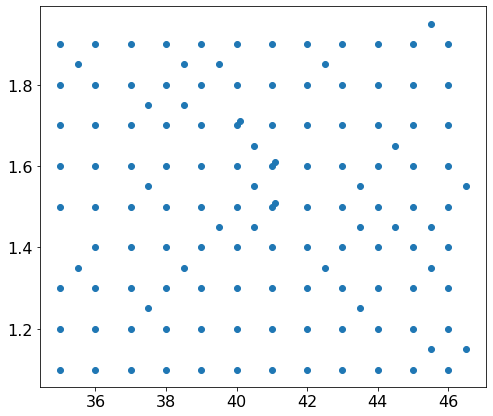

In [17]:
fig, ax = plt.subplots(figsize=(8,7))
gam = np.array(list(models.keys()))
ax.scatter(gam[:,0], gam[:,1]);

In [18]:
def uniform_sample(rg, limits, N):
    """ """
    lo = [x[0] for x in limits]
    hi = [x[1] for x in limits]
    return rg.uniform(lo, hi, (N, len(limits)))

In [19]:
def norm_sample(rg, samp, mult=10):
    norm_size = mult*samp.shape[0]
    limits = [[np.min(samp[:, i]), np.max(samp[:, i])] for i in range(samp.shape[1])]
    return uniform_sample(rg, limits, norm_size)

In [20]:
def unbinned_loglh(rg, model, sample):
    return -np.sum(np.log(model(sample))) +\
        sample.shape[0] * (np.log(np.mean(model(norm_sample(rg, sample, mult=100)))))

In [21]:
test_params = (44, 1.8)
sample = get_sample(*test_params, 250)[:5*10**3]
sample.shape

(5000, 3)

In [22]:
rg = np.random.Generator(np.random.PCG64())

In [23]:
mg_gsre, mg_gsim, lhmap = [], [], []
for (re, im), pdf in models.items():
    mg_gsre.append(re)
    mg_gsim.append(im)
    lhmap.append(unbinned_loglh(rg, pdf, sample))

In [24]:
def draw_spline_contours(ax, x, y, z, levels=10):
    newx, newy = np.meshgrid(
        np.linspace(np.min(x), np.max(x), 10),
        np.linspace(np.min(y), np.max(y), 10)
    )
    f = interpolate.griddata(
        np.column_stack([x, y]), z, (newx, newy),
        method='cubic'
    )
#     f = interpolate.interp2d(x, y, z, kind='cubic')
    cntf = ax.contourf(newx, newy, f, levels=levels);
    plt.colorbar(cntf, ax=ax);

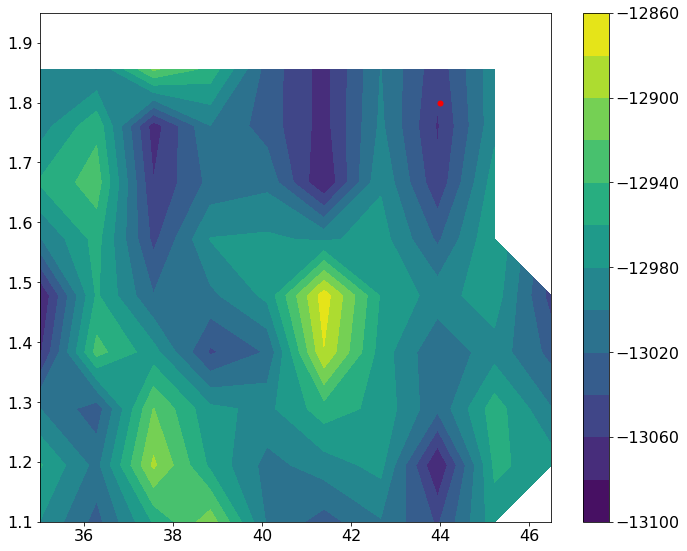

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
draw_spline_contours(ax, mg_gsre, mg_gsim, lhmap, levels=10)
ax.plot([test_params[0]], [test_params[1]], marker='.', markersize=10, color='r');
fig.tight_layout()
fig.savefig('loglh_scan.png')

In [27]:
lhscan = np.column_stack([mg_gsre, mg_gsim, lhmap])
lhscan.shape

(136, 3)

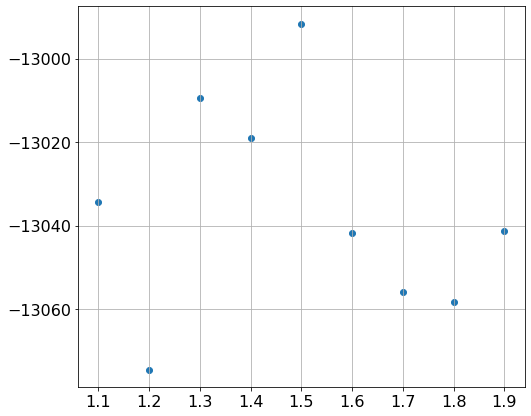

In [30]:
fig, ax = plt.subplots(figsize=(8,7))
mask = lhscan[:,0] == 44
ax.scatter(lhscan[mask][:, 1], lhscan[mask][:, 2])
ax.grid()